In [54]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [55]:
import tensorflow.keras
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp
from scipy.interpolate import interp1d

In [56]:
import pandas as pd
df=pd.read_csv('/content/jla.csv')

In [57]:
dmag =df["dmb"]

In [58]:
N = len(df.values)

In [59]:
df2=df['errors']+df['dmb']

(0.0, 1.5)

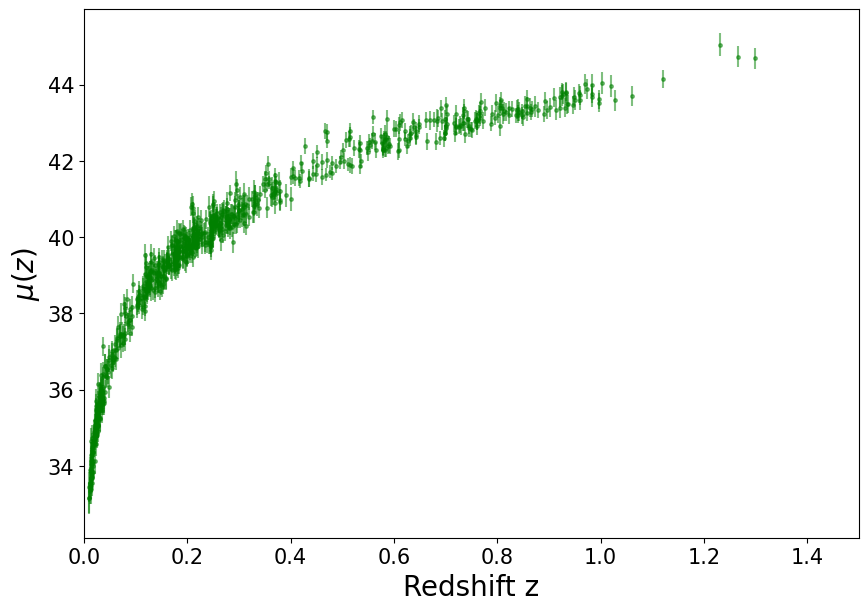

In [60]:
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(df['zcmb'], df['mb']+19, df2, fmt='g.', markersize=5, label='Observations', alpha=0.5)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.xscale('log')


plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlim(0, 1.5)

In [61]:
randomize = np.random.permutation(N)
data = df.values[randomize]

In [62]:
z = data[:,0]
y = data[:,1:] ### coge el resto de variables a predecir 
# print(randomize)

In [63]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

# scalery = MinMaxScaler(feature_range=(0,1))
# scalery = StandardScaler()
# scalery.fit(y)
# y = scalery.transform(y)

In [95]:
### Modificar para incluir phanteon como test
split = 0.7
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [94]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.01,
                                   patience=50.0,
                                   restore_best_weights=True)]
#                      tf.keras.callbacks.ReduceLROnPlateau(patience=2)]

COMBINACIONES ÓPTIMAS DE HIPERPARÁMETROS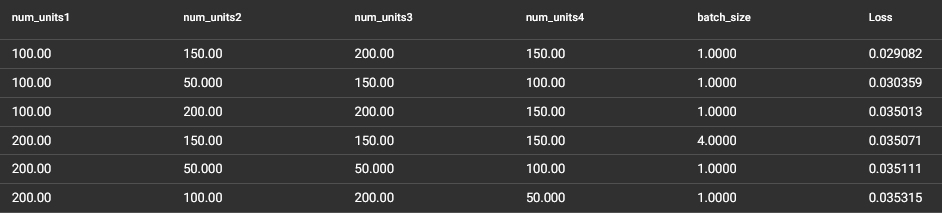

In [91]:
def model(input_z):
    efirst = Dense(100, activation='relu', input_shape=(1,))(input_z)
    ehidden = Dense(150, activation='relu')(efirst)
    ehidden2 = Dense(200, activation='relu')(ehidden)
    ehidden3 = Dense(150, activation='relu')(ehidden2)
    elast = Dense(3, activation='linear')(ehidden3) ### cambiar segun el número de variables a predecir
    return elast


input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_10 (Dense)            (None, 100)               200       
                                                                 
 dense_11 (Dense)            (None, 150)               15150     
                                                                 
 dense_12 (Dense)            (None, 200)               30200     
                                                                 
 dense_13 (Dense)            (None, 150)               30150     
                                                                 
 dense_14 (Dense)            (None, 3)                 453       
                                                                 
Total params: 76,153
Trainable params: 76,153
Non-trainable

In [92]:
batch_size = 1
epochs = 200
input_z = Input(shape = (1,))

In [96]:
model_train = neural_model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, y_test),
                                    callbacks=callbacks)

Epoch 1/200
626/626 [==============================] - 3s 4ms/step - loss: 12.9413 - val_loss: 0.2983
Epoch 2/200
626/626 [==============================] - 2s 3ms/step - loss: 0.2338 - val_loss: 0.0966
Epoch 3/200
626/626 [==============================] - 2s 3ms/step - loss: 0.1173 - val_loss: 0.1120
Epoch 4/200
626/626 [==============================] - 2s 3ms/step - loss: 0.2072 - val_loss: 0.1900
Epoch 5/200
626/626 [==============================] - 2s 3ms/step - loss: 0.1891 - val_loss: 0.2043
Epoch 6/200
626/626 [==============================] - 2s 3ms/step - loss: 0.0767 - val_loss: 0.1106
Epoch 7/200
626/626 [==============================] - 2s 3ms/step - loss: 0.1110 - val_loss: 0.0379
Epoch 8/200
626/626 [==============================] - 2s 3ms/step - loss: 0.2161 - val_loss: 0.2382
Epoch 9/200
626/626 [==============================] - 2s 3ms/step - loss: 0.1692 - val_loss: 0.5500
Epoch 10/200
626/626 [==============================] - 2s 3ms/step - loss: 0.1119 - val_l

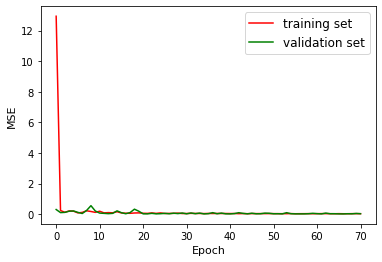

In [97]:
plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
# plt.savefig('loss_hz.png')

In [98]:
neural_model.save('FFNN_v2.h5')

In [99]:
pred = neural_model.predict(z_test)
pred

array([[23.391731  ,  0.16229168,  0.18924676],
       [24.058258  ,  0.17130898,  0.19518362],
       [23.487553  ,  0.1637642 ,  0.19052444],
       [16.596964  ,  0.13881406,  0.16186057],
       [20.02666   ,  0.1422761 ,  0.16302358],
       [15.198331  ,  0.14343607,  0.16431092],
       [21.129074  ,  0.14648929,  0.16883193],
       [22.385426  ,  0.15215689,  0.17753588],
       [23.07726   ,  0.15884864,  0.18528925],
       [15.180785  ,  0.14353295,  0.16434251],
       [15.652696  ,  0.14103055,  0.16368459],
       [21.969872  ,  0.1497315 ,  0.17441688],
       [16.198431  ,  0.13933215,  0.16276668],
       [21.891731  ,  0.14926142,  0.17375813],
       [21.761953  ,  0.1484802 ,  0.17266546],
       [20.261585  ,  0.14316744,  0.16428743],
       [21.545462  ,  0.14738543,  0.17099033],
       [17.255346  ,  0.13834548,  0.16041814],
       [21.755157  ,  0.14843968,  0.172608  ],
       [22.502522  ,  0.15307255,  0.1784905 ],
       [24.060007  ,  0.17133135,  0.195

In [100]:
# ranz = np.random.uniform(0, 2, size=10000)
ranz = np.linspace(0, 1.5, 1000)
r = scalerz.transform(ranz.reshape(-1, 1))
pred_random = neural_model.predict(r)
rr = scalerz.inverse_transform(r.reshape(-1,1))

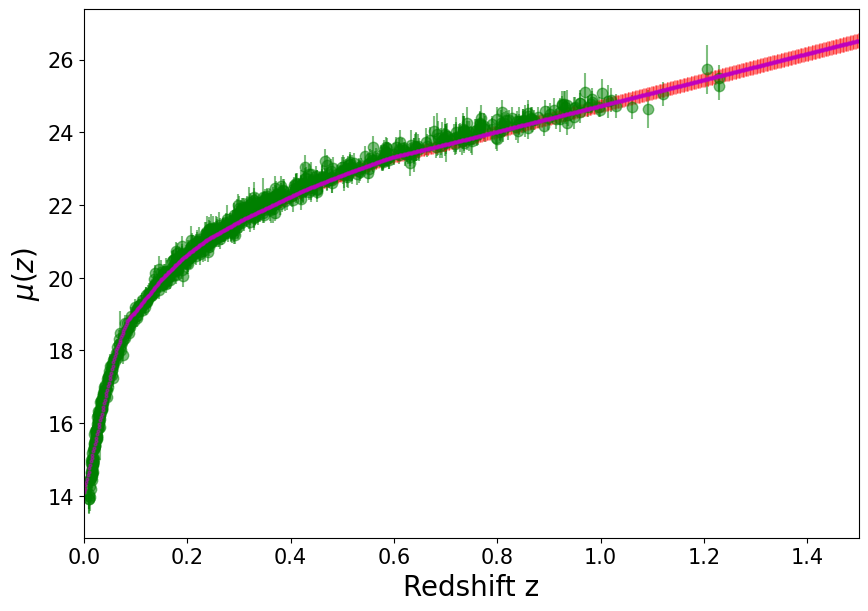

In [103]:
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(df['zcmb'], df['mb'], df2, fmt='g.', markersize=15, label='Observations', alpha=0.5)
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.5, c='m')
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlim(0, 1.5)
plt.savefig("errors_jla.png")

In [104]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

zmodel = np.linspace(0.01, 1.5, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

#     fowacdm1.append(distance_modulus(zzz, w0=-1.3, wa=1.2))
#     fowacdm1.append(distance_modulus(zzz, w0=-1.09, wa=0.3, Om=om))
#     fowacdm2.append(distance_modulus(zzz, w0=-1.04, wa=-0.3, Om=om))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
# fowacdm1 = np.array(fowacdm1)
# fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

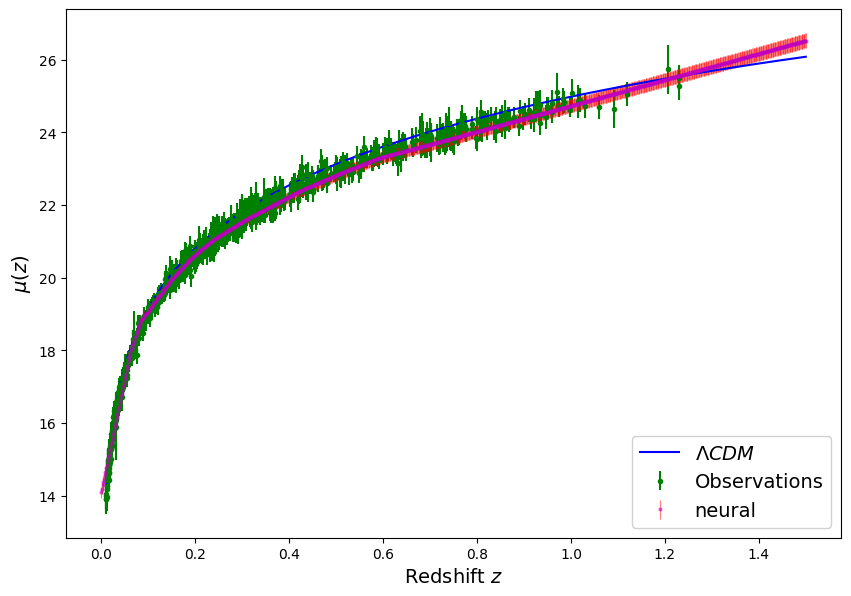

In [106]:
plt.figure(figsize=(10, 7), dpi=100)

plt.errorbar(df['zcmb'], df['mb'], yerr=df2, fmt='g.', label='Observations')
# plt.plot(df['zcmb'], df['mb'], c='g')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.5, c='m', label='neural')
plt.ylabel("$\mu(z)$", fontsize=14)
plt.legend(fontsize=14, loc='lower right', framealpha=0.9, ncol=1)

                            


plt.xlabel('Redshift $z$', fontsize=14)

plt.savefig("jla.png")

PREDICCIÓN SOBRE EL CONJUNTO DE PHANTEON TESTEO

In [107]:
import pandas as pd
df=pd.read_csv('/content/not_in _jla.csv')

In [ ]:
dmag =df["dmb"]

In [108]:
N = len(df.values)

In [109]:
df2=df['errors']+df['dmb']

(0.0, 1.5)

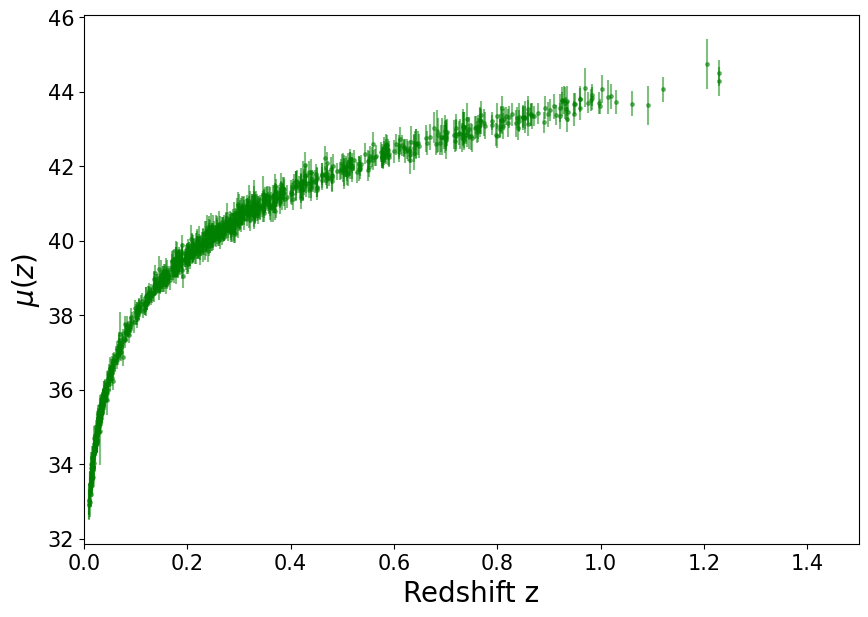

In [110]:
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(df['zcmb'], df['mb']+19, df2, fmt='g.', markersize=5, label='Observations', alpha=0.5)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.xscale('log')


plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlim(0, 1.5)

In [111]:
randomize = np.random.permutation(N)
data = df.values[randomize]

In [112]:
z = data[:,0]
y = data[:,1:] ### coge el resto de variables a predecir 
# print(randomize)

In [113]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

# scalery = MinMaxScaler(feature_range=(0,1))
# scalery = StandardScaler()
# scalery.fit(y)
# y = scalery.transform(y)

In [114]:
### Modificar para incluir phanteon como test
split = 0.0
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [115]:
len(z_test)

895

In [ ]:
from keras.models import load_model

In [ ]:
neural_model = load_model('/content/FFNN_v2.h5')

In [116]:
pred = neural_model.predict(z_test)
pred

array([[22.054466  ,  0.15023404,  0.17511116],
       [22.636438  ,  0.15455297,  0.1799091 ],
       [15.825035  ,  0.14018527,  0.16344641],
       ...,
       [23.912884  ,  0.16948973,  0.1944326 ],
       [21.341698  ,  0.14695069,  0.169932  ],
       [20.7819    ,  0.1452711 ,  0.167163  ]], dtype=float32)

In [117]:
# ranz = np.random.uniform(0, 2, size=10000)
ranz = np.linspace(0, 1.5, 1000)
r = scalerz.transform(ranz.reshape(-1, 1))
pred_random = neural_model.predict(r)
rr = scalerz.inverse_transform(r.reshape(-1,1))

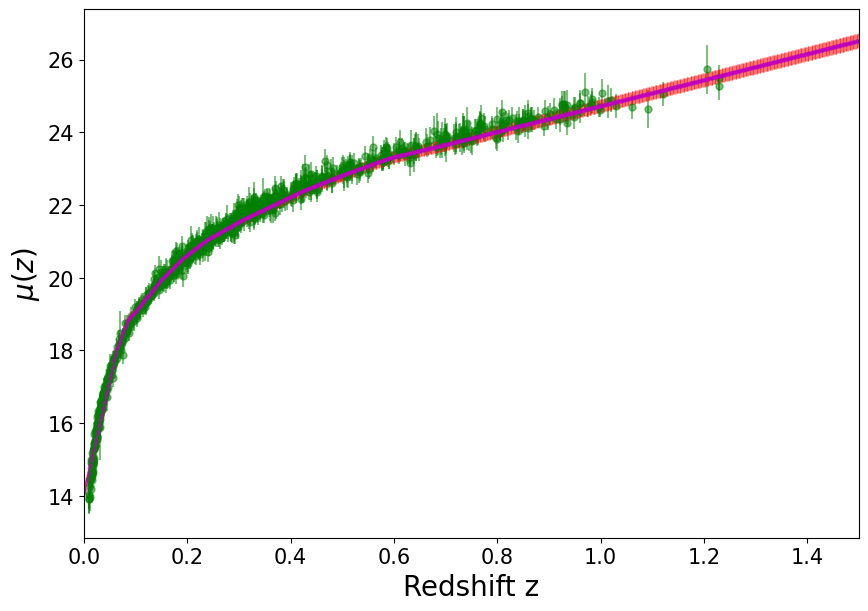

In [132]:
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(df['zcmb'], df['mb'], df2, fmt='g.', markersize=10, label='Observations', alpha=0.5)
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.5, c='m')

plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlim(0, 1.5)
plt.savefig("errors2.png")

In [129]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

zmodel = np.linspace(0.01, 1.5, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

#     fowacdm1.append(distance_modulus(zzz, w0=-1.3, wa=1.2))
#     fowacdm1.append(distance_modulus(zzz, w0=-1.09, wa=0.3, Om=om))
#     fowacdm2.append(distance_modulus(zzz, w0=-1.04, wa=-0.3, Om=om))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
# fowacdm1 = np.array(fowacdm1)
# fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

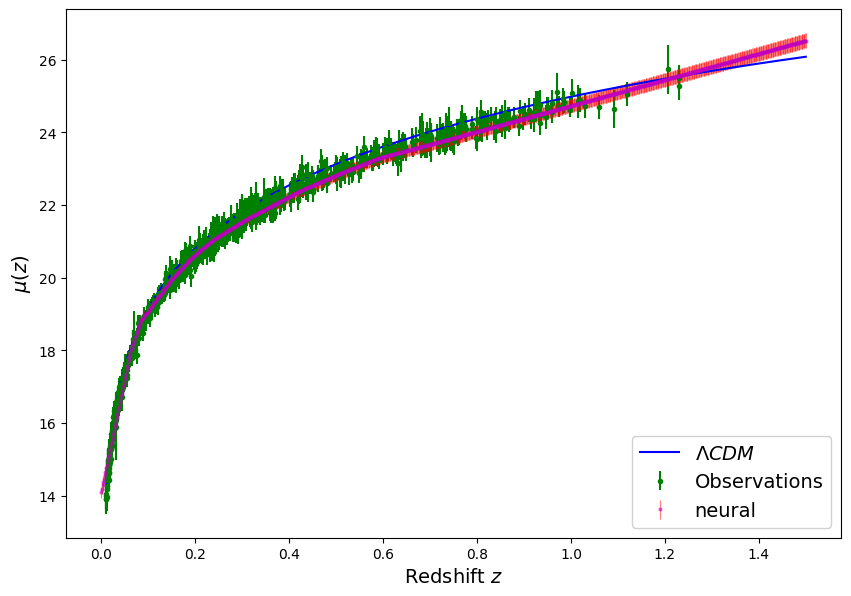

In [131]:
plt.figure(figsize=(10, 7), dpi=100)

plt.errorbar(df['zcmb'], df['mb'], yerr=df2, fmt='g.', label='Observations')
# plt.plot(df['zcmb'], df['mb'], c='g')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.5, c='m', label='neural')
plt.ylabel("$\mu(z)$", fontsize=14)
plt.legend(fontsize=14, loc='lower right', framealpha=0.9, ncol=1)

                            


plt.xlabel('Redshift $z$', fontsize=14)
plt.savefig("prediction2.png")